In [28]:
#Counteor for the number of errors in the grid
import os
from os.path import join
path = os.getcwd()
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pydoc import ispath
import pandas as pd
import h5py
import numpy as np

parent = os.path.abspath("..")
DBS = join(parent,"results","databases")



In [2]:

# Change this accordingly
CONFIGS = ["night_charging","prognosis", "random", "solar_charging", "max_P"]
scenarios = ["EV", "EV_PV", "EV_PV_STO", "GRID_OBSV"]

for CONFIG in CONFIGS:
    RESULTS_DIR = "C:\\Repos\\Simulation_Results\\results_march_smart_charging 220918"
    
    RESULTS_DB_DIR = RESULTS_DIR #join(RESULTS_DIR, "databases")
    GRID_SNAPS_DIR = join(RESULTS_DIR, "grid_snapshots")
    RESULTS_POSTPROC_DIR = join(RESULTS_DIR, "postprocessed")
    
    counter = {}
    counter_total = {}
    min_v_dict={}
    car_numbers = {}

    for scenario in scenarios:
        no_cars_list=[]
        counter[scenario]=[]
        counter_total[scenario]={}
        issues_list_by_car = []
        min_v_list = []

        for n_cars in range(49,500):
        # search if folder exists
            DB_NAME = join(RESULTS_DB_DIR,f"Results_{scenario}_{n_cars}_{CONFIG}.hdf5")
            if os.path.isfile(DB_NAME):
                #print("doing " + DB_NAME)
                #if scenario =="EV":
                try:
                    no_cars_list.append(n_cars)
                    data = h5py.File(DB_NAME, "r")
            
                    series = {}

                    # Which datarows do I want
                    series["bus"] = [b for b in data["Series"].keys() if "bus" in b.lower()]
                    if scenario == "GRID_OBSV":
                        series["bus"] = [b for b in data["Series"].keys() if "gridnode" in b.lower()]
                    results = {}
                    params = {}
                    output_list=[]
                    column_names = series["bus"]
                    par = "vm_pu"
                    for column in column_names:
                        output = data["Series"][column][par]
                        output = np.array(output)
                        output_list.append(output)
                        results[column.split("-")[-1]] = np.array(output)

                    df = pd.DataFrame(results)

                    #count how many values outside of the boundaries I have...
                    min_v = 1
                    violations= 0
                    for col in df.columns:
                        for x in df[col]:
                            if x<0.95:
                                violations+=1
                            if x<min_v:
                                min_v = x
                    min_v_list.append(min_v)



                    list_issues = []
                    list_issues_serious = []
                    for idx in df.index:
                        issue = 0 
                        voltages = [df.at[idx,c] for c in df.columns]
                        if min(voltages)<0.95:
                            issue=1
                        list_issues.append(issue)
                        
                        serious_issue= 0
                        if min(voltages)<0.90:
                            serious_issue=1
                        list_issues_serious.append(serious_issue)


                    issues_statistic=[]
                    issues_count =[]
                    # there are 96 values per day
                    # a maximum of 96*7/20
                    max_allowed = int(round(96*7/20))
                    for i, issue in enumerate(list_issues):
                        problem = 0

                        if i<=96*7:
                            sublist = list_issues[0:i+1]
                        else:
                            sublist = list_issues[i+1-96*7:i+1]
                            assert(len(sublist)==96*7)
                        week_issues = sublist.count(1)
                        issues_count.append(week_issues)
                        if week_issues >=max_allowed:
                            problem = 1
                        
                        if list_issues_serious[i]==1:
                            problem = 1


                        issues_statistic.append(problem)
                    issues_statistic_count=issues_statistic.count(1)
                    issues_list_by_car.append(issues_statistic_count)
                    counter_total[scenario][n_cars]=issues_count
                
                except:
                    print("error" + DB_NAME)



        car_numbers[scenario]= no_cars_list
        counter[scenario]=issues_list_by_car
        min_v_dict[scenario] = min_v_list

    import json
    with open(f"figs220919\\jsons\\march_car_numbers_{CONFIG}.json", "w") as write_file:
        json.dump(car_numbers, write_file, indent=4)

    with open(f"figs220919\\jsons\\march_car_results_{CONFIG}.json", "w") as write_file:
        json.dump(counter, write_file, indent=4)

    with open(f"figs220919\\jsons\\march_car_results_totals_{CONFIG}.json", "w") as write_file:
        json.dump(counter_total, write_file, indent=4)

    with open(f"figs220919\\jsons\\march_car_results_min_v_{CONFIG}.json", "w") as write_file:
        json.dump(min_v_dict, write_file, indent=4)



errorC:\Repos\Simulation_Results\results_march_smart_charging 220918\Results_EV_PV_329_night_charging.hdf5
errorC:\Repos\Simulation_Results\results_march_smart_charging 220918\Results_EV_PV_STO_315_prognosis.hdf5


In [29]:
import json
CONFIGS = ["max_p","night_charging","prognosis", "solar_charging"] #, "random",
min_v_df_results = []
for CONFIG in CONFIGS:
    with open(f"figs220919\\jsons\\march_car_results_min_v_{CONFIG}.json") as json_file:
        min_v_dict = json.load(json_file)

    with open(f"figs220919\\jsons\\march_car_numbers_{CONFIG}.json") as json_file:
        car_numbers = json.load(json_file)

    for scenario in scenarios:
        try:
            leng= min(len(car_numbers[scenario]),len(min_v_dict[scenario]))
            if CONFIG == "max_p":
                temp_dict = {"n_cars":car_numbers[scenario][0:leng],
                        f"Max. power - {scenario}": min_v_dict[scenario][0:leng]}
            
            else:    
                temp_dict = {"n_cars":car_numbers[scenario][0:leng],
                        f"{CONFIG} - {scenario}": min_v_dict[scenario][0:leng]}
            
            temp_df =   pd.DataFrame.from_dict(temp_dict) 
            temp_df.set_index("n_cars", inplace=True)

            min_v_df_results.append(temp_df)
        except:
            print(f"min_v_{scenario}_{CONFIG}")
 
min_res =  pd.concat(min_v_df_results, axis=1)
min_res

Max. power - EV  Max. power - EV_PV  Max. power - EV_PV_STO  \
n_cars                                                                
245            0.920297            0.921010                0.922504   
260            0.906064            0.906064                0.907611   
275            0.904203            0.904203                0.905757   
280            0.903718            0.903718                0.905273   
294            0.902793            0.902793                0.904351   
301            0.894717            0.894717                0.896307   
308            0.890052            0.890052                0.891659   
315            0.889653            0.889653                0.891261   
322            0.889014            0.889014                0.890624   
329            0.888430            0.888430                     NaN   
336                 NaN                 NaN                     NaN   
343                 NaN                 NaN                     NaN   
350                 NaN                 NaN                     NaN   

        Max. power - GRID_OBSV  night_charging - EV  night_charging - EV_PV  \
n_cars                                                                        
245                        NaN             0.924221                0.924221   
260                        NaN             0.915078                0.915078   
275                        NaN             0.913617                0.913617   
280                        NaN             0.913493                0.913493   
294                        NaN             0.912736                0.912736   
301                   0.901980             0.904859                0.904859   
308                   0.896946             0.900558                0.900558   
315                   0.896551             0.900130                0.900130   
322                   0.896551             0.899653                0.899653   
329                   0.895904             0.899220                     NaN   
336                   0.895003                  NaN                     NaN   
343                   0.894157                  NaN                     NaN   
350                   0.885590                  NaN                     NaN   

        night_charging - EV_PV_STO  night_charging - GRID_OBSV  \
n_cars                                                           
245                       0.930738                         NaN   
260                       0.916590                         NaN   
275                       0.915135                         NaN   
280                       0.915011                         NaN   
294                       0.914257                         NaN   
301                       0.906410                    0.922063   
308                       0.902475                    0.920493   
315                       0.902097                    0.920154   
322                       0.901680                    0.920154   
329                            NaN                    0.919476   
336                            NaN                    0.918772   
343                            NaN                    0.918103   
350                            NaN                    0.897341   

        prognosis - EV  prognosis - EV_PV  prognosis - EV_PV_STO  \
n_cars                                                             
245           0.946454           0.948318               0.954916   
260           0.941649           0.946705               0.950178   
275           0.940793           0.945980               0.949361   
280           0.940793           0.945934               0.949361   
294           0.940235           0.945222               0.948823   
301           0.934091           0.937808               0.942812   
308           0.931654           0.936231               0.940423   
315           0.931205           0.935888               0.939793   
322           0.931006           0.935865                    NaN   
329           0.9

In [30]:
# ev pv prognosis for 322 is missing
a = min_res.at[308,"prognosis - EV_PV_STO"]
b = min_res.at[315,"prognosis - EV_PV_STO"]
c= b-(a-b)
min_res.at[322,"prognosis - EV_PV_STO"] =c

cols = min_res.columns
cols_ev_pv_sto = [col for col in cols if "EV_PV_STO" in col]

for col in cols_ev_pv_sto:
    # a simple interpolation with the previous value
    a= min_res.at[315,col]
    b = min_res.at[322,col]
    c= b - (a-b) # evenly spaced then only the change in the step as next step
    print(c)
    min_res.at[329,col] =c



0.8899880429462468
0.9012637187387439
0.9385326765473745
0.9766232972938431


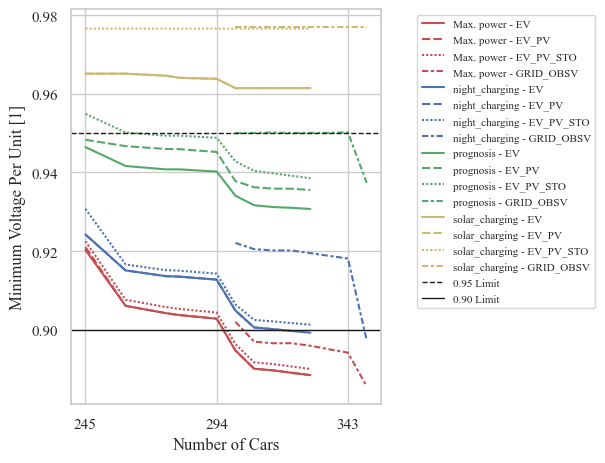

In [31]:
sns.set(font = "Times New Roman", style ="whitegrid")

fig,ax = plt.subplots()

pallette = ["r","b","g","y","m"]

for i in range(0,4):
    cols = min_res.columns[i*4:i*4+4]
    graph=sns.lineplot(data=min_res[cols],ax=ax, palette=[pallette[i]]*4)
    ax.set_xlabel("Number of Cars")
    ax.set_ylabel("Minimum Voltage Per Unit [1]")
    #ax.set_title("Minimum Voltage Levels for Different\nScenarios and Charging Strategies",fontweight="bold")
    graph.set_xticks([49*x for x in range(5,8)])

graph.axhline(0.95, label = "0.95 Limit",color='k',ls='--',linewidth=1)
graph.axhline(0.90, label = "0.90 Limit",color='k',linewidth=1)
ax.annotate("0.95 Limit", xy=(392, 0.951), size=10)
ax.annotate("0.90 Limit", xy=(392, 0.901), size=10)
#ax.legend(fontsize=6) # using a size in points

plt.legend(fontsize=8, bbox_to_anchor=(1.1, 1))
plt.tight_layout()
fig.savefig("figs220919\\min_voltage_smart_charging.png", dpi= 600)

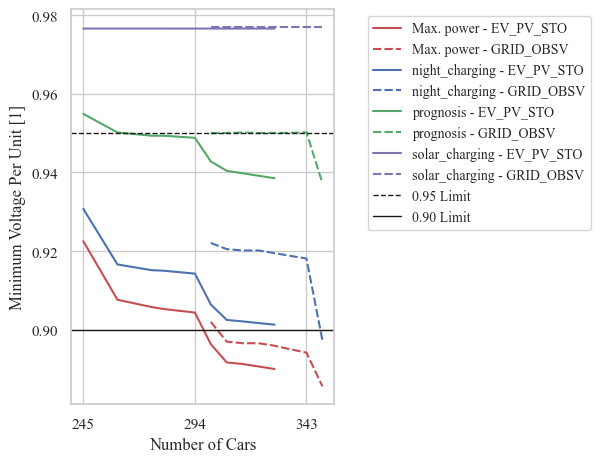

In [32]:
sns.set(font = "Times New Roman", style ="whitegrid")

fig,ax = plt.subplots()

pallette = ["r","b","g","m","y"]
CONFIGS = ["max_p","night_charging","prognosis", "solar_charging"] #, "random",

for i in range(0,4):
    cols = min_res.columns[i*4:i*4+4]
    cols = [x for x in cols  if "EV_PV_STO" in x or "GRID_OBSV" in x]

    graph=sns.lineplot(data=min_res[cols],ax=ax, palette=[pallette[i]]*2)
    ax.set_xlabel("Number of Cars")
    ax.set_ylabel("Minimum Voltage Per Unit [1]")
    #ax.set_title("Minimum Voltage Levels for Different\nScenarios and Charging Strategies",fontweight="bold")
    graph.set_xticks([49*x for x in range(5,8)])
   

graph.axhline(0.95, label = "0.95 Limit",color='k',ls='--',linewidth=1)
graph.axhline(0.90, label = "0.90 Limit",color='k',linewidth=1)
ax.annotate("0.95 Limit", xy=(392, 0.951), size=10)
ax.annotate("0.90 Limit", xy=(392, 0.901), size=10)
plt.legend(fontsize=10, bbox_to_anchor=(1.1, 1))
plt.tight_layout()
fig.savefig("figs220919\\min_voltage_smart_charging_lower.png", dpi= 600)

In [33]:
import json
CONFIGS = ["max_p","night_charging","prognosis", "solar_charging"]
df_results = []
for CONFIG in CONFIGS:
    with open(f"figs220918\\march_car_results_{CONFIG}.json") as json_file:
        counter = json.load(json_file)

    with open(f"figs220918\\march_car_numbers_{CONFIG}.json") as json_file:
        car_numbers = json.load(json_file)

    for scenario in scenarios:
        try:
            leng= min(len(car_numbers[scenario]),len(counter[scenario]))
            if CONFIG == "max_p":
                temp_dict = {"n_cars":car_numbers[scenario][0:leng],
                        f"{scenario}-max. power": counter[scenario][0:leng]}
            
            else:    
                temp_dict = {"n_cars":car_numbers[scenario][0:leng],
                        f"{scenario}-{CONFIG}": counter[scenario][0:leng]}
            
            temp_df =   pd.DataFrame.from_dict(temp_dict) 
            temp_df.set_index("n_cars", inplace=True)

            df_results.append(temp_df)
        except:
            print(f"min_v_{scenario}_{CONFIG}")
 
    res =  pd.concat(df_results, axis=1)


res

EV-max. power  EV_PV-max. power  EV_PV_STO-max. power  \
n_cars                                                          
245               0.0               0.0                   0.0   
260             192.0              86.0                   0.0   
275             194.0              88.0                   1.0   
280             196.0              90.0                   1.0   
294             271.0             193.0                   3.0   
301            1324.0             745.0                 175.0   
308            1647.0            1201.0                 568.0   
315            1648.0            1201.0                 572.0   
322            1651.0            1205.0                 572.0   
329            1720.0            1290.0                   NaN   
336               NaN               NaN                   NaN   
343               NaN               NaN                   NaN   
350               NaN               NaN                   NaN   

        GRID_OBSV-max. power  EV-night_charging  EV_PV-night_charging  \
n_cars                                                                  
245                      NaN                0.0                   0.0   
260                      NaN                0.0                   0.0   
275                      NaN                0.0                   0.0   
280                      NaN                0.0                   0.0   
294                      NaN                0.0                   0.0   
301                      0.0              262.0                   0.0   
308                      1.0              411.0                 183.0   
315                      1.0              473.0                 183.0   
322                      1.0              474.0                 184.0   
329                      1.0              475.0                   NaN   
336                      1.0                NaN                   NaN   
343                      1.0                NaN                   NaN   
350                    611.0                NaN                   NaN   

        EV_PV_STO-night_charging  GRID_OBSV-night_charging  EV-prognosis  \
n_cars                                                                     
245                          0.0                       NaN           0.0   
260                          0.0                       NaN           0.0   
275                          0.0                       NaN           0.0   
280                          0.0                       NaN           0.0   
294                          0.0                       NaN           0.0   
301                          0.0                       0.0           0.0   
308                          0.0                       0.0           0.0   
315                          0.0                       0.0           0.0   
322                          0.0                       0.0           0.0   
329                          NaN                       0.0           0.0   
336                          NaN                       0.0           NaN   
343                          NaN                       0.0           NaN   
350                          NaN                       1.0           NaN   

        EV_PV-prognosis  EV_PV_STO-prognosis  GRID_OBSV-prognosis  \
n_cars                                                              
245                 0.0                  0.0                  NaN   
260                 0.0                  0.0                  NaN   
275                 0.0                  0.0                  NaN   
280                 0.0                  0.0                  NaN   
294                 0.0                  0.0                  NaN   
301                 0.0                  0.0                  0.0   
308                 0.0                  0.0                  0.0   
315                 0.0                  0.0                  0.0   
322                 0.0                  NaN                  0.0   
329                 0.0             

In [36]:
limits = {}
limits["Scenario_full"]=[]
limits["Limit"]=[]

for scenario in res.columns:
    previous_idx = -1
    for idx in res.index:
        if res.loc[idx,scenario] == 0:
            limit = idx
    limits["Scenario_full"].append(scenario)
    limits["Limit"].append(limit)


with open(f"figs220918\\limits_results_new.json", "w") as write_file:
    json.dump(limits, write_file, indent=4)

df_limits = pd.DataFrame.from_dict(limits)
df_limits["Scenario"] = [x.split("-")[0] for x in df_limits["Scenario_full"]]
df_limits["Strategie"] = [x.split("-")[1] for x in df_limits["Scenario_full"]]

df_limits.drop(columns=['Scenario_full'], inplace=True)

df_limits_real = df_limits

df_limits.at[6,"Limit"]=329
df_limits.at[10,"Limit"]=329
df_limits.at[14,"Limit"]=329

df_limits

Limit   Scenario       Strategie
0     245         EV      max. power
1     245      EV_PV      max. power
2     260  EV_PV_STO      max. power
3     301  GRID_OBSV      max. power
4     294         EV  night_charging
5     301      EV_PV  night_charging
6     329  EV_PV_STO  night_charging
7     343  GRID_OBSV  night_charging
8     329         EV       prognosis
9     329      EV_PV       prognosis
10    329  EV_PV_STO       prognosis
11    350  GRID_OBSV       prognosis
12    329         EV  solar_charging
13    329      EV_PV  solar_charging
14    329  EV_PV_STO  solar_charging
15    350  GRID_OBSV  solar_charging

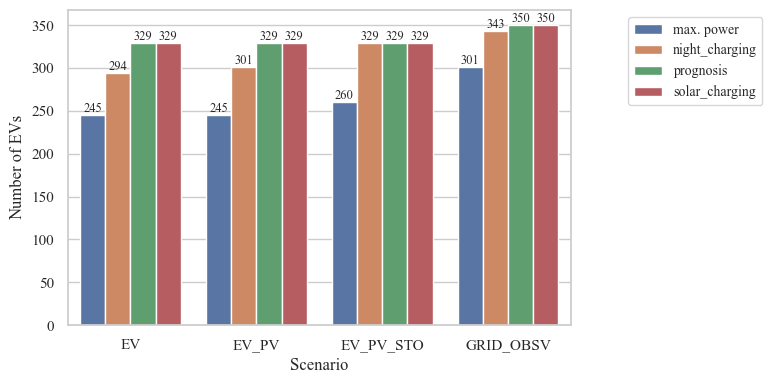

In [35]:

sns.set(font = "Times New Roman", style ="whitegrid")

fig,ax = plt.subplots(figsize=(8,4))
graph=sns.barplot(data=df_limits,x="Scenario", y="Limit", hue="Strategie")
for container in ax.containers:
    ax.bar_label(container,fontsize=9)

ax.set_xlabel("Scenario")
ax.set_ylabel("Number of EVs")
#ax.set_title("Minimum Voltage Levels for Different\nScenarios and Charging Strategies",fontweight="bold")
plt.legend(fontsize=10, bbox_to_anchor=(1.1, 1))
plt.tight_layout()
fig.savefig("figs220919\\bar_plt_strats.png", dpi= 600)

In [49]:
df_limits_real

Limit   Scenario       Strategie
0     245         EV      max. power
1     245      EV_PV      max. power
2     260  EV_PV_STO      max. power
3     301  GRID_OBSV      max. power
4     294         EV  night_charging
5     301      EV_PV  night_charging
6     329  EV_PV_STO  night_charging
7     343  GRID_OBSV  night_charging
8     329         EV       prognosis
9     329      EV_PV       prognosis
10    329  EV_PV_STO       prognosis
11    350  GRID_OBSV       prognosis
12    329         EV  solar_charging
13    329      EV_PV  solar_charging
14    329  EV_PV_STO  solar_charging
15    350  GRID_OBSV  solar_charging

In [83]:
CONFIGS = ["max_p","night_charging","prognosis", "solar_charging"] #, "random",
df_limits_violations = df_limits_real
res= {}
for CONFIG in CONFIGS:
    with open(f"figs220919\\jsons\\march_car_results_totals_{CONFIG}.json") as json_file:
        total_incidents = json.load(json_file)
        for scenario in scenarios:
            strat = CONFIG
            if CONFIG == "max_p":
                strat = "max. power"

            aa=df_limits_real[(df_limits_real["Scenario"]==scenario)&(df_limits_real["Strategie"]==strat)]
            key= aa["Limit"].tolist()[0]
            if str(key) in total_incidents[scenario].keys(): 
                key_2 = str(key) 
            else:
                key_2 = list(total_incidents[scenario].keys())[-1]
            list_vde = total_incidents[scenario][key_2]
            if CONFIG == "max_p":

                res[f"max. power - {scenario} - {key_2}"] =list_vde
            else:
                res[f"{CONFIG} - {scenario} - {key_2}"] =list_vde
            
data_plot = pd.DataFrame.from_dict(res)
data_plot

-

max. power - EV - 245  max. power - EV_PV - 245  \
0                         0                         0   
1                         0                         0   
2                         0                         0   
3                         0                         0   
4                         0                         0   
...                     ...                       ...   
2971                      9                         8   
2972                      9                         8   
2973                      9                         8   
2974                      9                         8   
2975                      9                         8   

      max. power - EV_PV_STO - 260  max. power - GRID_OBSV - 301  \
0                                0                             0   
1                                0                             0   
2                                0                             0   
3                                0                             0   
4                                0                             0   
...                            ...                           ...   
2971                            11                             4   
2972                            11                             4   
2973                            11                             4   
2974                            11                             4   
2975                            11                             4   

      night_charging - EV - 294  night_charging - EV_PV - 301  \
0                             0                             0   
1                             0                             0   
2                             0                             0   
3                             0                             0   
4                             0                             0   
...                         ...                           ...   
2971                          6                             6   
2972                          6                             6   
2973                          6                             6   
2974                          6                             6   
2975                          6                             6   

      night_charging - EV_PV_STO - 322  night_charging - GRID_OBSV - 343  \
0                                    0                                 0   
1                                    0                                 0   
2                                    0                                 0   
3                                    0                                 0   
4                                    0                                 0   
...                                ...                               ...   
2971                                 7                                 0   
2972                                 7                                 0   
2973                                 7                                 0   
2974                                 7                                 0   
2975                                 7                                 0   

      prognosis - EV - 329  prognosis - EV_PV - 329  \
0                        0                        0   
1                        0                        0   
2                        0                        0   
3                        0                        0   
4                        0                        0   
...                    ...                      ...   
2971                     1                        1   
2972                     1                        1   
2973                     1                        1   
2974                     1                        1   
2975                     1                        1   

      prognosis - EV_PV_STO - 322  prognosis - GRID_OBSV - 350  \
0                               0                            0   
1                

In [89]:
#need to rename some columns
cols = [x for x in data_plot.columns if "EV_PV_STO" in x]
new_cols = ['max. power - EV_PV_STO - 260',
 'night_charging - EV_PV_STO - 329',
 'prognosis - EV_PV_STO - 329',
 'solar_charging - EV_PV_STO - 329']
data_plot.rename(columns = {cols[i]:new_cols[i] for i in range(1,4) }, inplace=True)
data_plot

max. power - EV - 245  max. power - EV_PV - 245  \
Time                                                                   
2020-03-04 00:00:00                      0                         0   
2020-03-04 00:15:00                      0                         0   
2020-03-04 00:30:00                      0                         0   
2020-03-04 00:45:00                      0                         0   
2020-03-04 01:00:00                      0                         0   
...                                    ...                       ...   
2020-04-03 22:45:00                      9                         8   
2020-04-03 23:00:00                      9                         8   
2020-04-03 23:15:00                      9                         8   
2020-04-03 23:30:00                      9                         8   
2020-04-03 23:45:00                      9                         8   

                     max. power - EV_PV_STO - 260  \
Time                                                
2020-03-04 00:00:00                             0   
2020-03-04 00:15:00                             0   
2020-03-04 00:30:00                             0   
2020-03-04 00:45:00                             0   
2020-03-04 01:00:00                             0   
...                                           ...   
2020-04-03 22:45:00                            11   
2020-04-03 23:00:00                            11   
2020-04-03 23:15:00                            11   
2020-04-03 23:30:00                            11   
2020-04-03 23:45:00                            11   

                     max. power - GRID_OBSV - 301  night_charging - EV - 294  \
Time                                                                           
2020-03-04 00:00:00                             0                          0   
2020-03-04 00:15:00                             0                          0   
2020-03-04 00:30:00                             0                          0   
2020-03-04 00:45:00                             0                          0   
2020-03-04 01:00:00                             0                          0   
...                                           ...                        ...   
2020-04-03 22:45:00                             4                          6   
2020-04-03 23:00:00                             4                          6   
2020-04-03 23:15:00                             4                          6   
2020-04-03 23:30:00                             4                          6   
2020-04-03 23:45:00                             4                          6   

                     night_charging - EV_PV - 301  \
Time                                                
2020-03-04 00:00:00                             0   
2020-03-04 00:15:00                             0   
2020-03-04 00:30:00                             0   
2020-03-04 00:45:00                             0   
2020-03-04 01:00:00                             0   
...                                           ...   
2020-04-03 22:45:00                             6   
2020-04-03 23:00:00                             6   
2020-04-03 23:15:00                             6   
2020-04-03 23:30:00                             6   
2020-04-03 23:45:00                             6   

                     night_charging - EV_PV_STO - 329  \
Time                                                    
2020-03-04 00:00:00                                 0   
2020-03-04 00:15:00                                 0   
2020-03-04 00:30:00                                 0   
2020-03-04 00:45:00                                 0   
2020-03-04 01:00:00                                 0   
...                                               ...   
2020-04-03 22:45:00                                 7   
2020-04-03 23:00:00                                 7   
2020-04-03 23:15:00                                 7   
2020-04-03 23:30:00                 

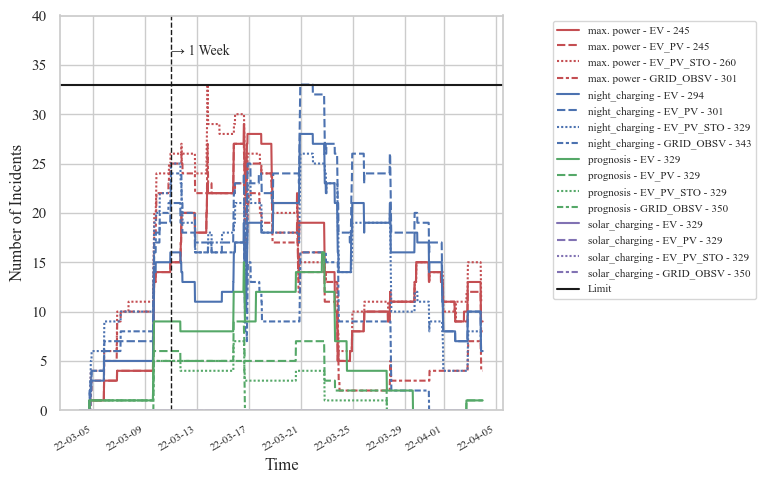

In [92]:


import warnings
warnings.filterwarnings('ignore')
sns.set(font = "Times New Roman", style ="whitegrid")

dti = pd.date_range(start="2022-03-04", periods=data_plot.shape[0], freq="15T")
data_plot["Time"] = dti
data_plot.set_index("Time", inplace=True)

CONFIGS = ["max. power","night_charging","prognosis","solar_charging"]
pallette = ["r","b","g","m","y"]

fig,ax = plt.subplots(figsize=(8,5))

for i in range(4):
    cols = data_plot.columns
    cols = [c for c in cols if CONFIGS[i] in c]
    graph = sns.lineplot(data=data_plot[cols],ax=ax, palette= [pallette[i]]*4 )

graph.axhline(33, label = "Limit",color='k',linewidth=1.5)
graph.axvline(dti[96*7],color='k', ls='--',linewidth=1)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Incidents")
#ax.set_title(f"Statistical Voltage Issues for Scenario {scenario}",fontweight="bold")
ax.set_ylim(bottom=0, top=40)
#x_dates = dti.strftime('%y-%m-%d %H:%M').sort_values().unique()

#ax.set_xticklabels(labels=x_dates, rotation=45, ha='right', fontsize= 8)

ax.annotate("→ 1 Week", xy=(dti[96*7], 36), size=10)
plt.legend(fontsize=8, bbox_to_anchor=(1.1, 1))
#ax.fmt_xdata = DateFormatter('%yy-% m-% d ')
plt.xticks(fontsize=8)#, rotation=90)
import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%y-%m-%d')# %H:%M')
ax.xaxis.set_major_formatter(myFmt)
fig.autofmt_xdate()

plt.tight_layout()
fig.savefig(f"figs220919\\timeseries_voltage_issues.png", dpi = 600)